# ResNet Ablation Study

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## Step 0. 데이터셋 불러오기
### 텐서플로우 cats_vs_dogs 데이터셋

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋 다운로드
import urllib3
urllib3.disable_warnings()

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'], # train : validation = 8 : 2
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


- cats_vs_dogs 데이터셋을 다운로드 받기 위해 참고한 코드를 사용해보며 약간의 변경도 해봤지만 DownloadError를 해결할 수 없었다. 구글의 도움을 받아 에러를 해결하는 방법을 찾아봤는데 url 설정이 잘못되어 나타난 에러인 거 같다. 그래서 setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")을 통해 url 설정을 제대로 해주고 나니까 다운로드가 제대로 잘 되었다.

In [4]:
# feature 정보를 확인(Tensorflow 데이터셋 로드 시 필수)
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


### Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# cats_vs_dogs 클래스 개수
ds_info.features["label"].num_classes

2

In [9]:
# cats_vs_dogs 클래스 이름
ds_info.features["label"].names

['cat', 'dog']

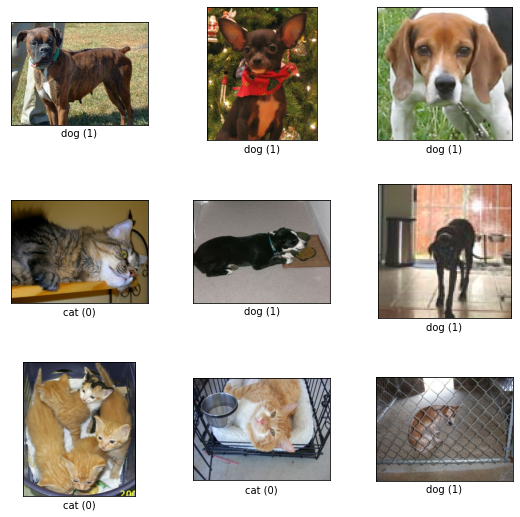

In [10]:
# train set 예시
fig = tfds.show_examples(ds_train, ds_info)

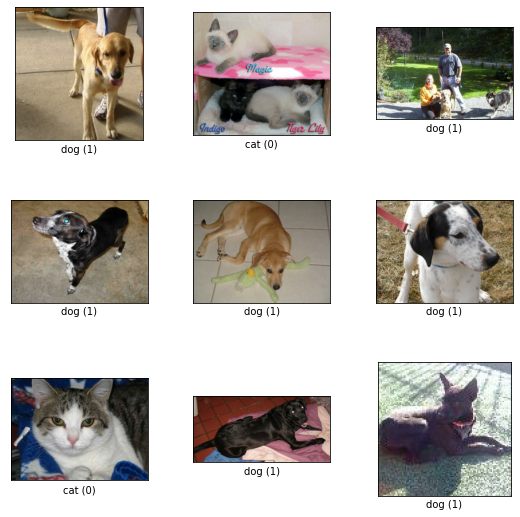

In [11]:
# validation set 예시
fig = tfds.show_examples(ds_val, ds_info)

## Step 1. ResNet 기본 블록 구성하기

![ResNet구조](https://user-images.githubusercontent.com/116326867/212613874-df38d83c-1d7d-49f7-9caf-d13e2e1a2e32.png)

In [ ]:
def convolutional_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=1,
                       is_50 = False, # is_50 : True == resnet_50
                       is_plain = False # is_plain : True == no skip connection 
                      ):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

In [12]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=1,
                       is_50 = False, # is_50 : True == resnet_50
                       is_plain = False # is_plain : True == no skip connection 
                      ):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    # ResNet-34
    if not is_50:
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            # ResNet-34 plain
            else:
                pass
    # ResNet-50
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        # ResNet-50 plain
        else:
            pass
    
    # Max Pooling 레이어
    # 마지막 블록 후에는 max pooling이 아닌 average pooling
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

## Step 2. ResNet-34, ResNet-50 Complete Model 및 일반 네트워크(plain network) 만들기

In [13]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10, is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=120, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### ResNet-34 vs Plain-34

In [23]:
plain_34 = build_resnet(input_shape=(224,224,3), is_50 = False, is_plain = True)
plain_resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 112, 112, 64) 832         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 112, 112, 64) 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_68[0][0]     
____________________________________________________________________________________________

In [24]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50 = False)
resnet_34.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   832         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 8, 8, 64)     0           batch_normalization_153[0][0]    
____________________________________________________________________________________________

### ResNet-50 vs Plain-50

In [25]:
plain_50 = build_resnet(input_shape=(224,224,3), is_50 = True, is_plain = True)
plain_resnet_50.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 112, 112, 64) 832         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 112, 112, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

In [26]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50 = True)
resnet_50.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 16, 16, 64)   832         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_187 (BatchN (None, 16, 16, 64)   256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 8, 8, 64)     0           batch_normalization_187[0][0]    
___________________________________________________________________________________________

## Step 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### Ablation Study(ResNet-34 vs Plain-34)

In [22]:
BATCH_SIZE = 32
EPOCH = 20

In [42]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)

In [44]:
plain_34 = build_resnet(input_shape=(224, 224, 3), 
                        num_classes=1, 
                        is_50=False,
                        is_plain=True)

In [45]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:18 - loss: 3.4822 - accuracy: 0.4906

 40/581 [=>............................] - ETA: 1:16 - loss: 2.8860 - accuracy: 0.4953

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:06 - loss: 2.1001 - accuracy: 0.5086

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 36s - loss: 1.1907 - accuracy: 0.4970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 34s - loss: 1.1714 - accuracy: 0.4982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 33s - loss: 1.1576 - accuracy: 0.4979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 29s - loss: 1.1239 - accuracy: 0.4986

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 28s - loss: 1.1170 - accuracy: 0.4977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9729 - accuracy: 0.4968

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 146s 169ms/step - loss: 0.9729 - accuracy: 0.4968 - val_loss: 0.6972 - val_accuracy: 0.5002
Epoch 2/20
 30/581 [>.............................] - ETA: 1:18 - loss: 0.7004 - accuracy: 0.4729

 41/581 [=>............................] - ETA: 1:17 - loss: 0.6997 - accuracy: 0.4817

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:06 - loss: 0.6963 - accuracy: 0.4866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 37s - loss: 0.6964 - accuracy: 0.4957

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 35s - loss: 0.6965 - accuracy: 0.4955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 33s - loss: 0.6964 - accuracy: 0.4962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 29s - loss: 0.6963 - accuracy: 0.4955

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 29s - loss: 0.6963 - accuracy: 0.4954

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.4981

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.4982

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 95s 163ms/step - loss: 0.6960 - accuracy: 0.4982 - val_loss: 0.6942 - val_accuracy: 0.5121
Epoch 3/20
 32/581 [>.............................] - ETA: 1:17 - loss: 0.6927 - accuracy: 0.4746

 42/581 [=>............................] - ETA: 1:16 - loss: 0.6939 - accuracy: 0.4814

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 62/581 [==>...........................] - ETA: 1:13 - loss: 0.6940 - accuracy: 0.4924

KeyboardInterrupt: 

In [48]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                        num_classes=1, 
                        is_50=False,
                        is_plain=False)

In [49]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

histoty_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:18 - loss: 5.5057 - accuracy: 0.4677

 40/581 [=>............................] - ETA: 1:16 - loss: 4.4619 - accuracy: 0.4664

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 1:06 - loss: 2.0326 - accuracy: 0.4882

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/581 [======>.......................] - ETA: 1:01 - loss: 1.6972 - accuracy: 0.4942

KeyboardInterrupt: 

### 시각화(ResNet-34 vs Plain-34)

In [ ]:
# 훈련 손실(training loss) 비교 시각화
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_34', 'resnet_34'], loc='upper left')
plt.show()

In [ ]:
# 검증 정확도(validation accuracy) 비교 시각화
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_34', 'resnet_34'], loc='upper left')
plt.show()

### Ablation Study(ResNet-50 vs Plain-50)

In [ ]:
plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_plain_50 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_50 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 시각화(ResNet-50 vs Plain-50)

In [ ]:
# 훈련 손실(training loss) 비교 시각화
plt.plot(histoty_plain_50.history['loss'], 'r')
plt.plot(histoty_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_50', 'resnet_50'], loc='upper left')
plt.show()

In [ ]:
# 검증 정확도(validation accuracy) 비교 시각화
plt.plot(histoty_plain_50.history['val_accuracy'], 'r')
plt.plot(histoty_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_50', 'resnet_50'], loc='upper left')
plt.show()

--------

## 회고

## Reference
- [cats_vs_dogs 데이터셋 다운로드](https://wikidocs.net/50861)  
- [데이터셋 다운로드 에러 해결방법](https://stackoverflow.com/questions/72199498/error-in-importing-cats-vs-dogs-dataset-in-google-colab)
- [ResNet 구현하기](https://hwanny-yy.tistory.com/12)